In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [24]:
import arviz as az
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS, Predictive
import pandas as pd
import seaborn as sns
from tqdm.notebook import tqdm

numpyro.set_host_device_count(8)
numpyro.enable_x64()
sns.set_theme('notebook', 'ticks', 'colorblind')

In [3]:
def jnp_logsumexp(xs, axis=None):
    xs = jnp.atleast_1d(xs)

    x_max = jnp.max(xs, axis=axis)
    if axis is not None:
        x_max_expanded = jnp.expand_dims(x_max, axis=axis)
    else:
        x_max_expanded = x_max

    return x_max + jnp.log(jnp.sum(jnp.exp(xs - x_max_expanded), axis=axis))

Let's build a reasonable LIGO-ish observational model.  We're gonna do BBH systems here (because why not).  So the true masses are distributed as a power law in $m_1$, power law in $q$ conditional on $m_1$, gaussian in $\chi_\mathrm{eff}$ with a small offset mean, and delta-function in $\delta \phi$.  The variable ordering is $\delta \phi$, $\chi_\mathrm{eff}$, $q$, $m_1$.

In [4]:
nobs = 100
nnormal = 2
ndim = 4

alpha_true = 2.35
beta_true = 0.0 # p(q) ~ q^beta => p(1/q) d(1/q) = p(q) dq => p(1/q) 1/q^2 dq = p(q) dq => p(1/q) = q^2 p(q) => p(1/q) = (1/q)^-(beta+2)
chi_mu = 0.1
chi_sigma = 0.15

delta_phis = np.zeros(nobs)
chi_eff = np.random.normal(loc=chi_mu, scale=chi_sigma, size=nobs)
q_invs = 1 + np.random.pareto(beta_true+1, size=nobs)
qs = 1/q_invs
m1s = 1 + np.random.pareto(alpha_true-1, size=nobs)

The observational model is a bit different, and meant to be evocative of the sorts of correlations among observed variables that occur in the pN expansion.  Let 
$$
M_c = m_1 \frac{q^{3/5}}{\left( 1 + q \right)^{1/5}}
$$
be the chirp mass.  Then let "observed" variables 
$$
x = \log M_c + \delta \phi
$$
$$
y = \log M_c + q
$$
$$
z = \log M_c - q
$$
and 
$$
w = (1 + q) \chi_\mathrm{eff}.
$$

Let the observational uncertainties be independent and Gaussian with 
$$
\sigma_{x,y,z,w} = \left[ 0.01, 0.1, 0.1, 0.1 \right].
$$

The code below implements this observational model, and produces posterior samples over $\delta \phi$, $\chi_\mathrm{eff}$, $q$, and $m_1$.

In [5]:
mcs = m1s * qs**(3/5) / (1+qs)**(1/5)
xts = np.log(mcs) + delta_phis
yts = np.log(mcs) + qs
zts = np.log(mcs) - qs
wts = (1 + qs)*chi_eff

xos = np.random.normal(loc=xts, scale=0.01)
yos = np.random.normal(loc=yts, scale=0.1)
zos = np.random.normal(loc=zts, scale=0.1)
wos = np.random.normal(loc=wts, scale=0.1)

In [6]:
nsamp = 128

dpsamps = []
cesamps = []
qsamps = []
m1samps = []
for i in tqdm(range(nobs)):
    xo = xos[i]
    yo = yos[i]
    zo = zos[i]
    wo = wos[i]

    xsamps = np.random.normal(loc=xo, scale=0.01, size=nsamp)
    ysamps = np.random.normal(loc=yo, scale=0.1, size=nsamp)
    zsamps = np.random.normal(loc=zo, scale=0.1, size=nsamp)
    wsamps = np.random.normal(loc=wo, scale=0.1, size=nsamp)

    mc = np.exp(0.5*(ysamps + zsamps))
    q = 0.5*(ysamps - zsamps)
    dp = xsamps - np.log(mc)
    ce = wsamps / (1 + q)
    m1 = mc / (q**(3/5)/(1+q)**(1/5))

    while np.any(q < 0) or np.any(q > 1) or np.any(m1 < 1):
        s = (q < 0) | (q > 1) | (m1 < 1)
        n = np.sum(s)

        xsamps = np.random.normal(loc=xo, scale=0.01, size=n)
        ysamps = np.random.normal(loc=yo, scale=0.1, size=n)
        zsamps = np.random.normal(loc=zo, scale=0.1, size=n)
        wsamps = np.random.normal(loc=wo, scale=0.1, size=n)

        mc[s] = np.exp(0.5*(ysamps + zsamps))
        q[s] = 0.5*(ysamps - zsamps)
        dp[s] = xsamps - np.log(mc[s])
        ce[s] = wsamps / (1 + q[s])
        m1[s] = mc[s] / (q[s]**(3/5) / (1 + q[s])**(1/5))
    dpsamps.append(dp)
    cesamps.append(ce)
    qsamps.append(q)
    m1samps.append(m1)

dpsamps = np.array(dpsamps)
cesamps = np.array(cesamps)
qsamps = np.array(qsamps)
m1samps = np.array(m1samps)

normal_wts = np.ones_like(m1samps)
other_wts = 2*(1+qsamps)/m1samps

samples = np.stack((dpsamps, cesamps, qsamps, m1samps), axis=2)

  0%|          | 0/100 [00:00<?, ?it/s]

/var/folders/kh/yn7djbsx35vb_gqd5m31brm00000gq/T/ipykernel_68372/3886111987.py:22: RuntimeWarning: invalid value encountered in power
  m1 = mc / (q**(3/5)/(1+q)**(1/5))
/var/folders/kh/yn7djbsx35vb_gqd5m31brm00000gq/T/ipykernel_68372/3886111987.py:37: RuntimeWarning: invalid value encountered in power
  m1[s] = mc[s] / (q[s]**(3/5) / (1 + q[s])**(1/5))


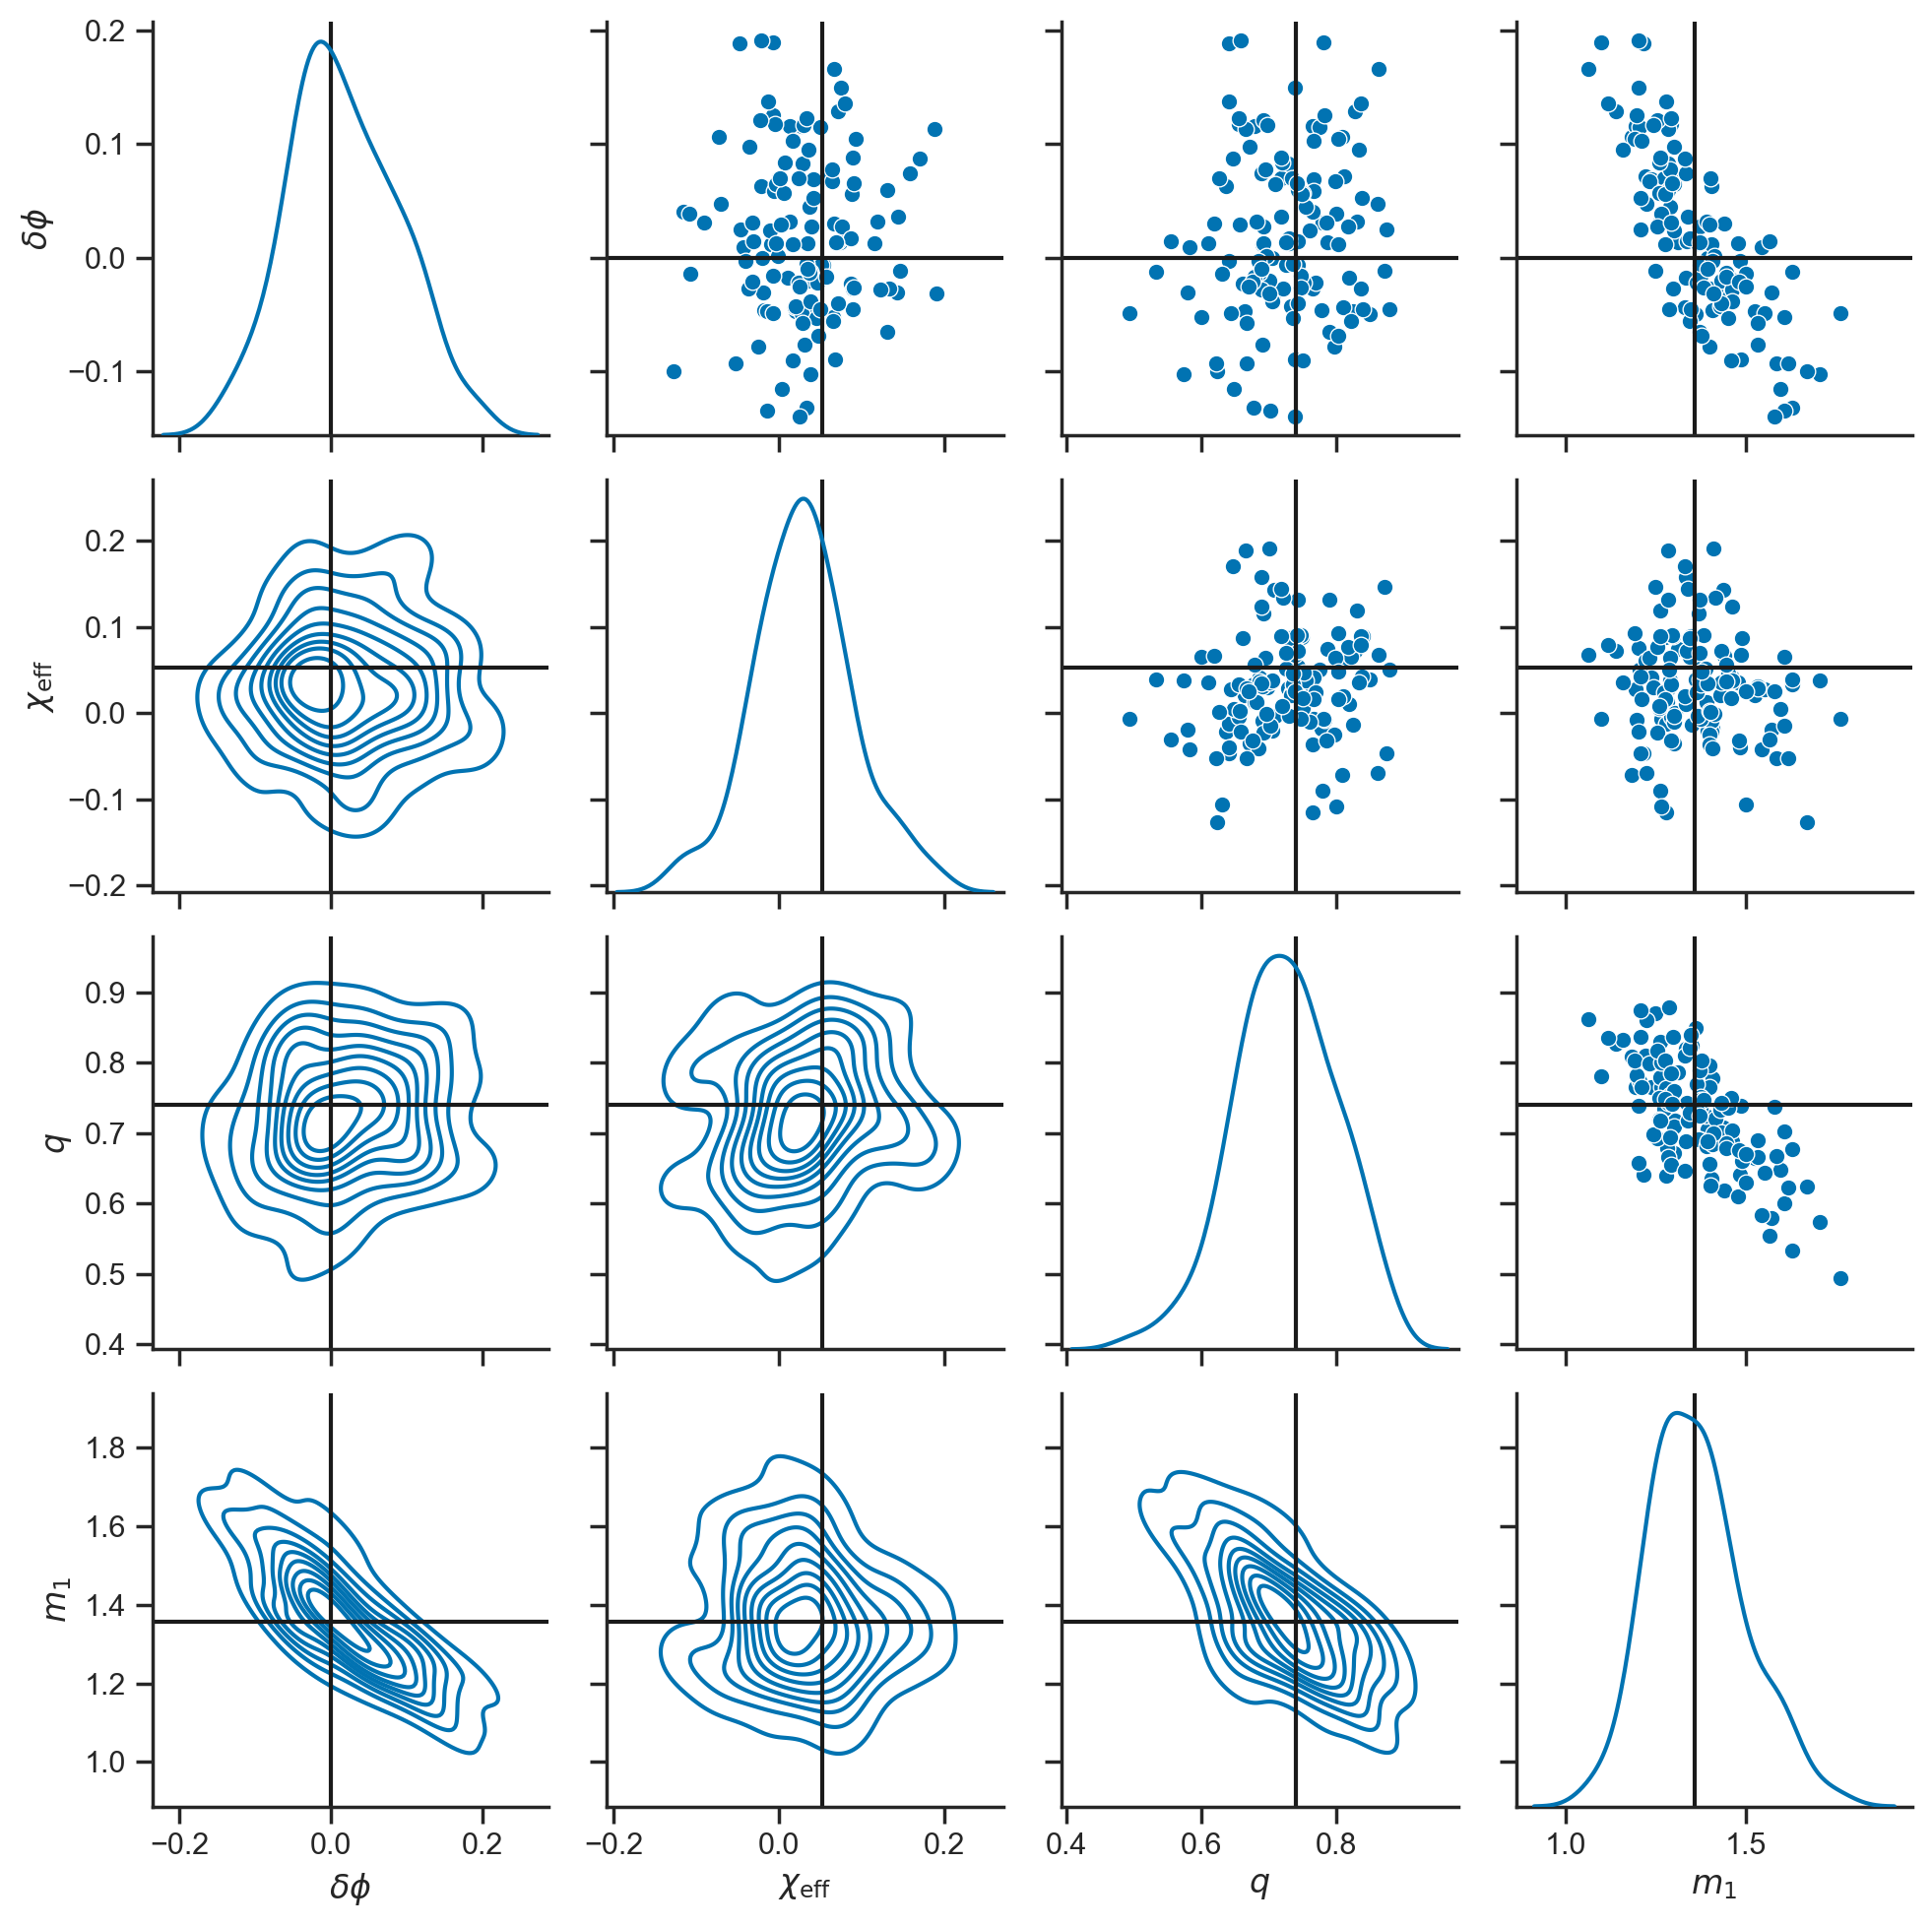

In [7]:
i = np.random.randint(nobs)
df = pd.DataFrame(data=samples[i,:,:], columns=[r'$\delta \phi$', r'$\chi_\mathrm{eff}$', r'$q$', r'$m_1$'])
pg = sns.PairGrid(df, diag_sharey=False)
pg.map_diag(sns.kdeplot)
pg.map_lower(sns.kdeplot)
pg.map_upper(sns.scatterplot)

t = [delta_phis[i], chi_eff[i], qs[i], m1s[i]]
for ii in range(4):
    for jj in range(4):
        if ii == jj:
            pg.axes[ii,jj].axvline(t[ii], color='k')
        else:
            pg.axes[ii,jj].axhline(t[ii], color='k')
            pg.axes[ii,jj].axvline(t[jj], color='k')

In [57]:
def make_conditional_normal_model(log_p_other, samples, prior_wts, n_normal, *args, predictive=False, **kwargs):
    samples = np.atleast_3d(samples)
    prior_wts = np.atleast_2d(prior_wts)

    ndim = samples.shape[-1]
    nsamp = samples.shape[-2]

    mu = np.mean(samples, axis=-2)
    cov = np.sum((samples[..., :, :, np.newaxis] - mu[..., np.newaxis, :, np.newaxis])*(samples[..., :, np.newaxis, :] - mu[..., np.newaxis, np.newaxis, :]), axis=-3)/nsamp

    ccov = np.linalg.inv(np.linalg.inv(cov)[..., :n_normal, :n_normal])
    kde_bw = ccov / nsamp**(2/(4+n_normal))

    mu = numpyro.sample('mu', dist.Normal(0,1), sample_shape=(n_normal,))
    sigma = numpyro.sample('sigma', dist.HalfNormal(0,1), sample_shape=(n_normal,))

    bw = kde_bw + jnp.diag(jnp.square(sigma))
    log_prob_normal = dist.MultivariateNormal(mu, bw[..., jnp.newaxis, :, :]).log_prob(samples[..., :n_normal])
    log_prob_other = log_p_other(samples[..., n_normal:])
    log_prob_total = log_prob_normal + log_prob_other
    log_prob_summed = jnp_logsumexp(log_prob_total, axis=-1)

    neff = numpyro.deterministic('neff', jnp.exp(2*log_prob_summed - jnp_logsumexp(2*log_prob_total, axis=-1)))
    
    numpyro.factor('loglike', jnp.sum(log_prob_summed))

def make_marginal_normal_model(log_p_other, samples, prior_wts, n_normal, *args, predictive=False, **kwargs):
    samples = np.atleast_3d(samples)
    prior_wts = np.atleast_2d(prior_wts)
    n_normal = nnormal

    ndim = samples.shape[-1]
    nobs = samples.shape[0]

    wts = 1/prior_wts
    W = np.sum(wts, axis=-1)
    neff = np.square(W) / np.sum(np.square(wts), axis=-1)

    log_wts = np.log(wts)

    mu = np.sum(wts[..., np.newaxis]*samples, axis=-2)/W[..., np.newaxis]
    sigma = np.sum(wts[..., np.newaxis, np.newaxis]*(samples[..., :, :, np.newaxis] - mu[..., np.newaxis, :, np.newaxis])*(samples[..., :, np.newaxis, :] - mu[..., np.newaxis, np.newaxis, :]), axis=-3) / W[..., np.newaxis, np.newaxis]

    kde_bw = sigma / neff[..., np.newaxis, np.newaxis]**(2/(4 + ndim))

    max_bw = np.max(kde_bw, axis=0)
    max_bw = np.max(np.diag(max_bw)[n_normal:])

    mu = numpyro.sample('mu', dist.Normal(0,1), sample_shape=(n_normal,))
    sigmas = numpyro.sample('sigma', dist.HalfNormal(1), sample_shape=(n_normal,))

    mu_full = jnp.concatenate((mu, jnp.zeros(ndim-n_normal)))

    eye_full = jnp.eye(ndim)
    upper = eye_full[:, :n_normal]
    lower = eye_full[:, n_normal:]

    # We only need the upper (n_normal, n_normal) corner of Lambda to be non-zero
    Lambda = upper @ jnp.diag(jnp.square(sigmas)) @ upper.T 
    # Lambda_upper = Lambda_upper + lower @ jnp.eye(ndim-n_normal) @ lower.T

    T_axes = np.arange(len(kde_bw.shape))
    T_axes[-2], T_axes[-1] = T_axes[-1], T_axes[-2]
    kb_T = jnp.transpose(kde_bw, axes=T_axes)

    Q = eye_full + jnp.transpose(jnp.linalg.solve(kb_T, Lambda[jnp.newaxis, ...]), axes=T_axes)

    mue = mu_full[..., jnp.newaxis]

    U = lower
    VT = jnp.transpose(jnp.linalg.solve(kb_T, lower[jnp.newaxis, ...]), T_axes)
    VTQIU = VT @ jnp.linalg.solve(Q, U[jnp.newaxis, ...])
    QI_mu = jnp.linalg.solve(Q, mue[jnp.newaxis, ...])

    mu_term = (QI_mu - U @ jnp.linalg.solve(VTQIU, VT @ QI_mu))[...,0]

    es = samples[..., jnp.newaxis]
    kb = kde_bw[..., jnp.newaxis, :, :]
    U = upper
    samples_term = (es - kb @ U @ jnp.linalg.solve(jnp.diag(jnp.square(sigmas)) + U.T @ kb @ U, U.T @ es))[..., 0]

    a = mu_term[..., jnp.newaxis, :] + samples_term

    B = kde_bw[..., :n_normal, :n_normal] + jnp.diag(jnp.square(sigmas))

    logp_normal = dist.MultivariateNormal(mu, B[..., jnp.newaxis, :, :]).log_prob(samples[..., :n_normal])
    logp_other_0 = log_p_other(a[..., n_normal:])

    logp_total = logp_normal + logp_other_0 + log_wts
    logp_sum = jnp_logsumexp(logp_total, axis=-1)

    neff = numpyro.deterministic('neff', jnp.exp(2*logp_sum - jnp_logsumexp(2*logp_total, axis=-1)))

    numpyro.factor('likelihood', jnp.sum(logp_sum))

    if predictive:
        inds = numpyro.sample('inds', dist.CategoricalLogits(logp_total))
        kb = jnp.array(kb)
        kb_i = kb[jnp.arange(nobs), inds, :, :]
        UTe = jnp.expand_dims(U.T, axis=0)

        A = kb_i - kb_i @ U @ jnp.linalg.solve(jnp.diag(jnp.square(sigmas)) + U.T @ kb_i @ U, UTe) @ kb_i
        a_i = a[jnp.arange(nobs), inds, :]
        theta = numpyro.sample('theta', dist.MultivariateNormal(a_i, A))

def make_full_model(marginal_model, samples, prior_wts, n_normal, *args, **kwargs):
    alpha = numpyro.sample('alpha', dist.Uniform(1, 4))
    beta = numpyro.sample('beta', dist.Uniform(0, 4))

    def log_p_other(s):
        q = s[..., 0]
        m1 = s[..., 1]

        log_m1 = jnp.log(jnp.abs(m1))
        log_q = jnp.log(jnp.abs(q))

        log_smooth_m = jnp.where(m1 < 1, -0.5*jnp.square(log_m1/0.05), 0)

        return beta*log_q + jnp.log1p(beta) - alpha*log_m1 + jnp.log(alpha - 1) + log_smooth_m
    
    marginal_model(log_p_other, samples, prior_wts, n_normal, *args, **kwargs)

In [35]:
nmcmc = 1000
nchain = 4

kernel = NUTS(make_full_model, dense_mass=True)
mcmc = MCMC(kernel, num_warmup=nmcmc, num_samples=nmcmc, num_chains=nchain)
mcmc.run(jax.random.PRNGKey(np.random.randint(1<<32)), make_marginal_normal_model, samples, normal_wts*other_wts, nnormal)

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

In [58]:
pred = Predictive(make_full_model, mcmc.get_samples())
a_pred = pred(jax.random.PRNGKey(np.random.randint(1<<32)), make_marginal_normal_model, samples, normal_wts*other_wts, nnormal, predictive=True)['theta']

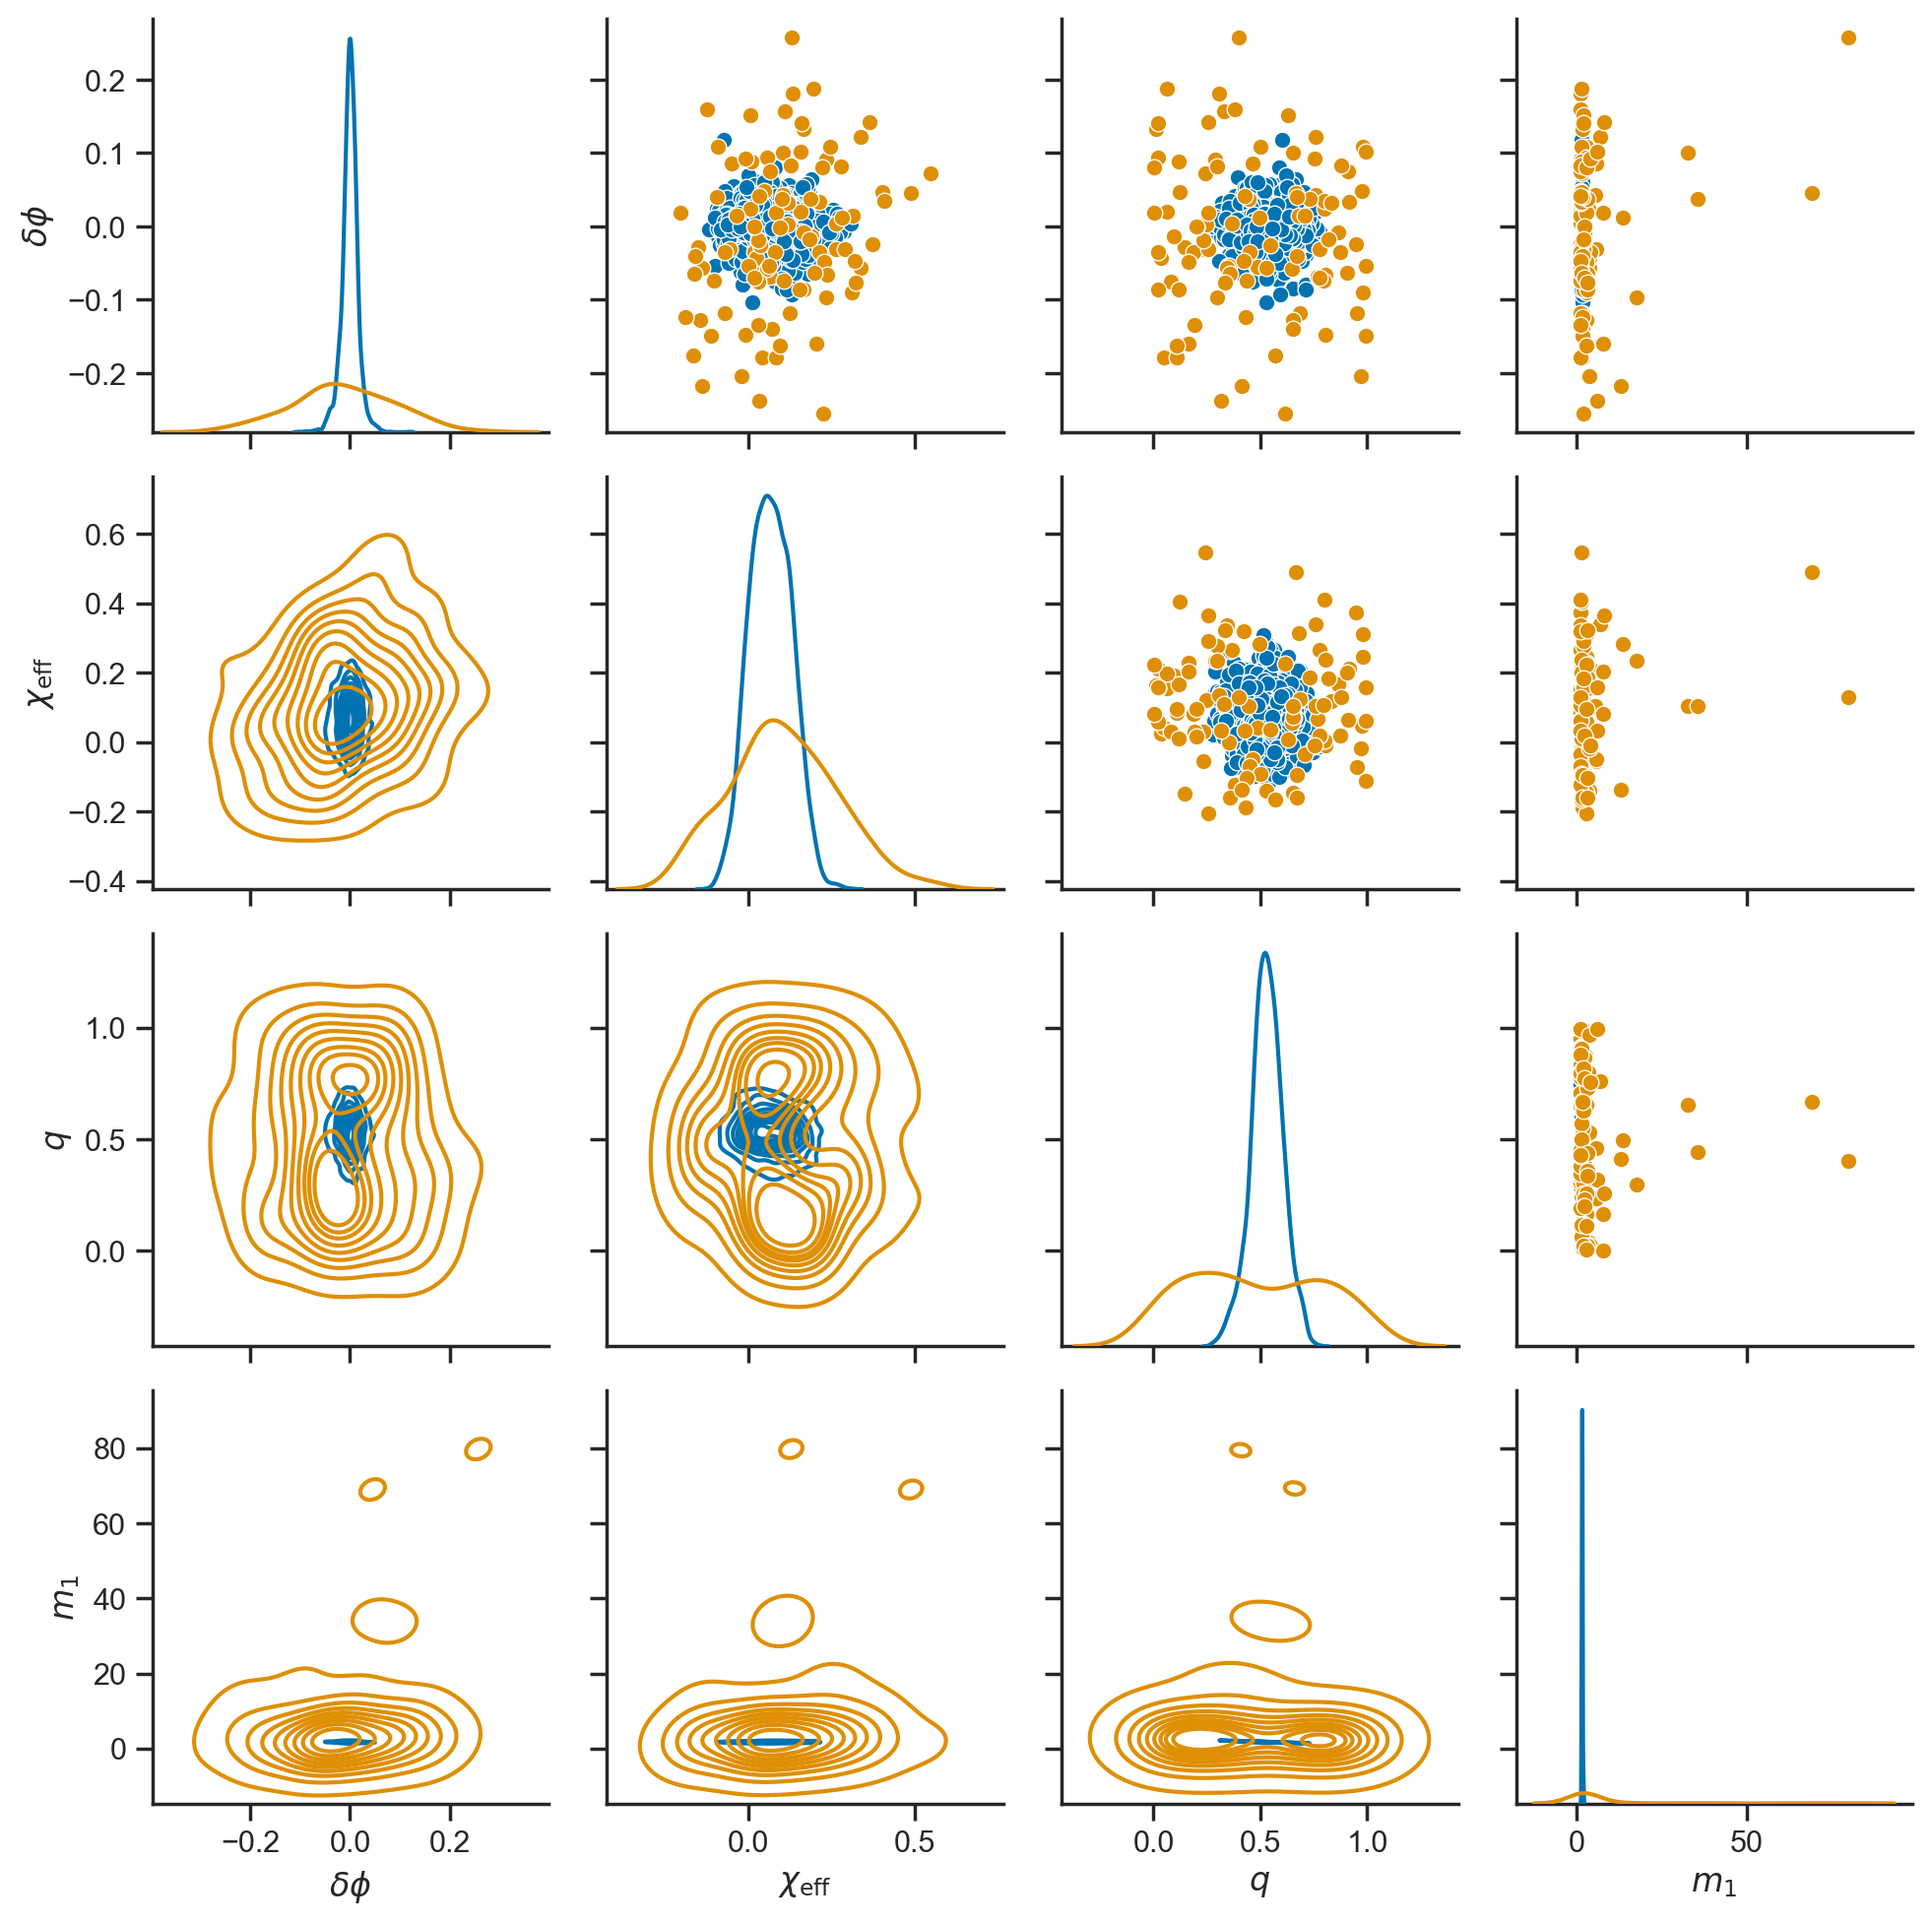

In [66]:
i = np.random.randint(nobs)
df = pd.DataFrame(a_pred[:,i,:], columns=[r'$\delta\phi$', r'$\chi_\mathrm{eff}$', r'$q$', r'$m_1$'])
pg = sns.PairGrid(df, diag_sharey=False)
pg.map_diag(sns.kdeplot)
pg.map_lower(sns.kdeplot)
pg.map_upper(sns.scatterplot)

df = pd.DataFrame(samples[:,i,:], columns=[r'$\delta\phi$', r'$\chi_\mathrm{eff}$', r'$q$', r'$m_1$'])
pg.data = df
pg.map_diag(sns.kdeplot)
pg.map_lower(sns.kdeplot)
pg.map_upper(sns.scatterplot)

In [62]:
trace = az.from_numpyro(mcmc)

array([[<Axes: title={'center': 'mu'}>, <Axes: title={'center': 'mu'}>],
       [<Axes: title={'center': 'sigma'}>,
        <Axes: title={'center': 'sigma'}>],
       [<Axes: title={'center': 'alpha'}>,
        <Axes: title={'center': 'alpha'}>],
       [<Axes: title={'center': 'beta'}>,
        <Axes: title={'center': 'beta'}>],
       [<Axes: title={'center': 'neff'}>,
        <Axes: title={'center': 'neff'}>]], dtype=object)

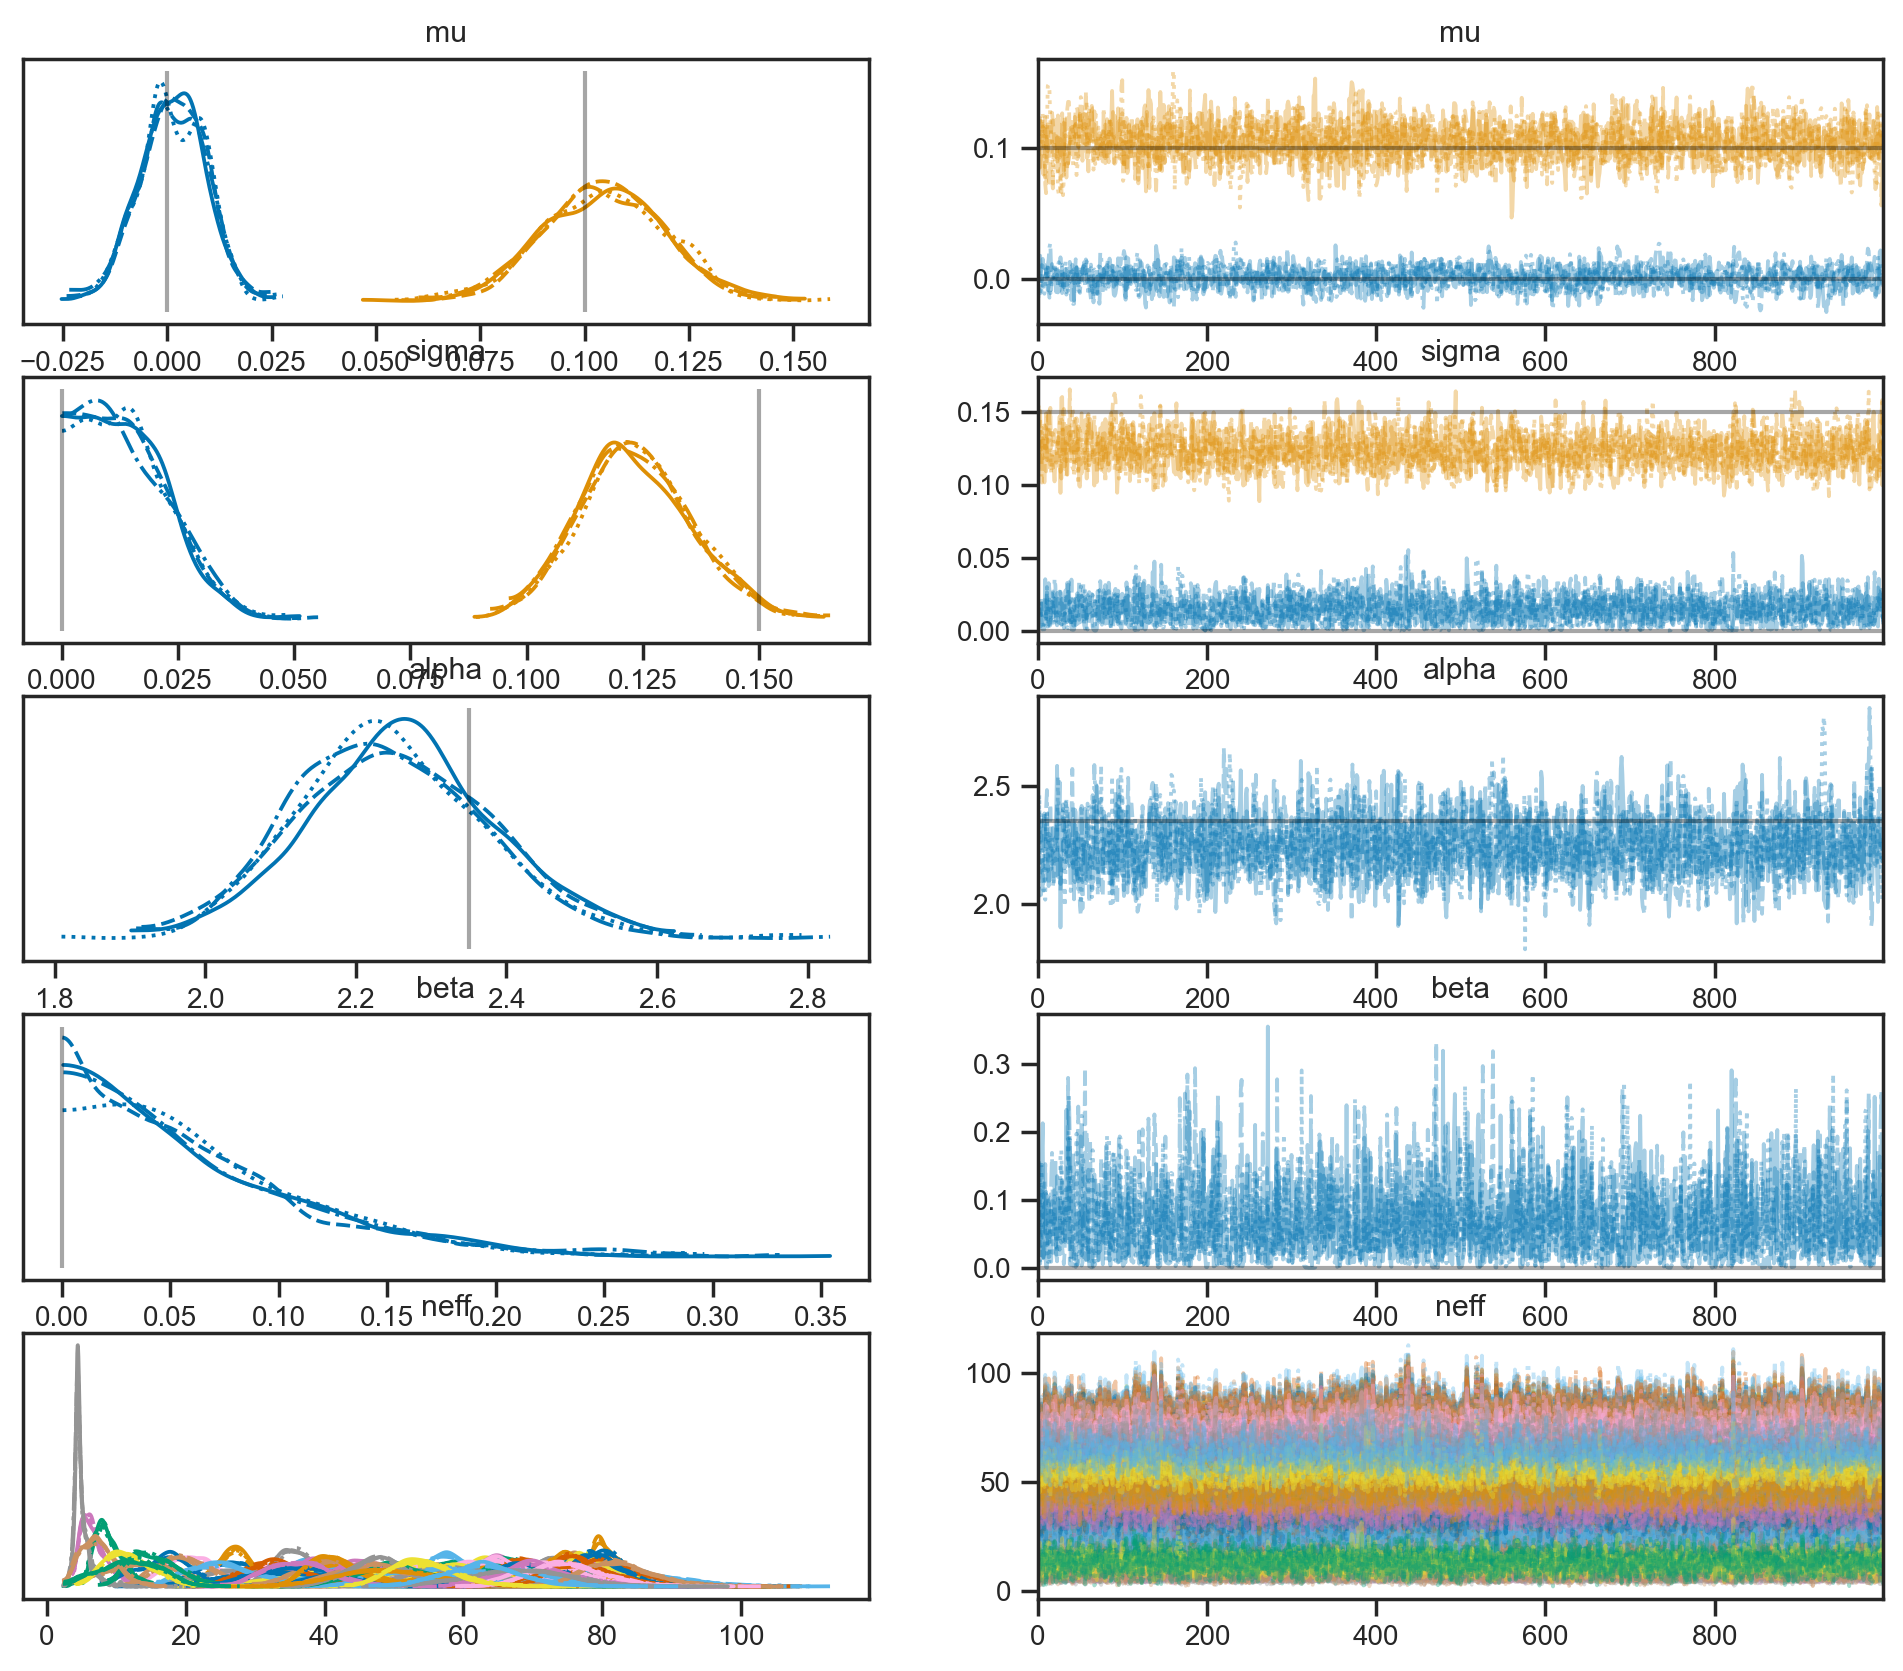

In [63]:
az.plot_trace(trace, var_names=['mu', 'sigma', 'alpha', 'beta', 'neff'], lines=[('mu', {}, np.array([0.0, chi_mu])), ('sigma', {}, np.array([0.0, chi_sigma])), 
                                                                                ('alpha', {}, alpha_true), ('beta', {}, beta_true)])

In [64]:
imin = trace.posterior.neff.min(dim=['chain', 'draw']).argmin()
trace.posterior.neff.min()

<xarray.DataArray 'neff' ()>
array(2.09888613)